In [1]:
from __future__ import print_function
import tifffile
import cv2
import numpy as np
import imutils


MAX_FEATURES = 5000
GOOD_MATCH_PERCENT = 0.15

In [2]:
def alignImages(im1, im2, im3):

  # Convert images to grayscale
  im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
  im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
  
  # Detect ORB features and compute descriptors.
  orb = cv2.ORB_create(MAX_FEATURES)
  keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
  keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
  
  # Match features.
  matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
  matches = matcher.match(descriptors1, descriptors2, None)
  
  # Sort matches by score
  matches.sort(key=lambda x: x.distance, reverse=False)

  # Remove not so good matches
  numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
  matches = matches[:numGoodMatches]

  # Draw top matches
  imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
#   cv2.imwrite("matches.jpg", imMatches)
  
  # Extract location of good matches
  points1 = np.zeros((len(matches), 2), dtype=np.float32)
  points2 = np.zeros((len(matches), 2), dtype=np.float32)

  for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt
  
  # Find homography
  h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

  # Use homography
  height, width, channels = im2.shape
  im3Reg = cv2.warpPerspective(im3, h, (width, height))
  im1Reg = cv2.warpPerspective(im1, h, (width, height))
  
  return im3Reg,im1Reg, h

Reading reference image :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_54_10.jpg


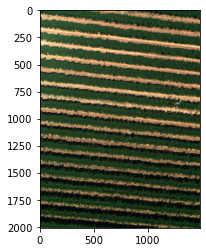

In [3]:
import os, glob, gdal
# put all images in the same folder (reflectance panel and the rest)
path_inputs_jpg = (r'C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected')   
path_outputs_jpg = (r'C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_aligned')

path_inputs_tif = (r'C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\stacks_selected')   
path_outputs_tif = (r'C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\stacks_aligned')

# Read reference image
refFilename = os.path.join(path_inputs_jpg,'Capture18_54_10.jpg')
print("Reading reference image : ", refFilename)

imReference = cv2.imread(refFilename,cv2.IMREAD_UNCHANGED)
imReference = cv2.cvtColor(imReference, cv2.COLOR_BGR2RGB)

rotated = imutils.rotate_bound(imReference, -90)

im1Gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)

import matplotlib.pyplot as plt
plt.imshow(rotated)

In [5]:
import math

files_jpg = glob.glob(path_inputs_jpg+'/*.jpg')
# files_tif = glob.glob(path_inputs_tif+'/*.tif')

inclination = []


for file in files_jpg:

    # Read image to be aligned
    # imFilename = "Capture19_03_35.1.jpg"
    print("Reading image to align : ", file);  

    im_original_jpg = cv2.imread(file,cv2.IMREAD_UNCHANGED)

    filename = os.path.split(file)
    filename_ = filename[-1]
        
    im_original_tif = tifffile.imread(path_inputs_tif+'\\'+filename_[:-3]+'tif')
    
   
    b= im_original_tif[0, :,:]
    g= im_original_tif[1, :,:]
    r= im_original_tif[2, :,:]
    re=im_original_tif[3, :,:]
    nir=im_original_tif[4, :,:]
    tir=im_original_tif[5, :,:]
        

#     rgb=np.dstack((r,g,b))
    alllayers=np.dstack((tir,nir,r))
    
    rgb_tif = imutils.rotate_bound(alllayers, -90)
    rgb_tif = (rgb_tif).astype('uint16')
    rgb_jpg = imutils.rotate_bound(im_original_jpg, -90)



    print("Aligning images ...")
    # Registered image will be resotred in imReg. 
    # The estimated homography will be stored in h. 
    tifReg, jpgReg, H = alignImages(rgb_jpg, rotated, rgb_tif)
    
    aa = H[0, 0]
    ba = H[0, 1]
    theta = math.atan2(ba, aa) * (180 / 3.1416)
    
    outFilename_tif = filename_[:-3]+'tif'
    outFilename_jpg = filename_[:-3]+'jpg'

    inclination.append([outFilename_tif,theta])
    # Write aligned image to disk. 

    print("Saving aligned image : ", outFilename_tif); 
    cv2.imwrite(os.path.join(path_outputs_tif,outFilename_tif), tifReg)
    cv2.imwrite(os.path.join(path_outputs_jpg,outFilename_jpg), jpgReg)


    


Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_45_53.jpg
Aligning images ...
Saving aligned image :  Capture18_45_53.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_45_56.jpg
Aligning images ...
Saving aligned image :  Capture18_45_56.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_45_57.jpg
Aligning images ...
Saving aligned image :  Capture18_45_57.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_45_58.jpg
Aligning images ...
Saving aligned image :  Capture18_45_58.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_45_59.jpg
Aligning images ...
Savi

Aligning images ...
Saving aligned image :  Capture18_46_44.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_46_45.jpg
Aligning images ...
Saving aligned image :  Capture18_46_45.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_46_46.jpg
Aligning images ...
Saving aligned image :  Capture18_46_46.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_46_48.jpg
Aligning images ...
Saving aligned image :  Capture18_46_48.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_46_49.jpg
Aligning images ...
Saving aligned image :  Capture18_46_49.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture18_47_33.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_47_34.jpg
Aligning images ...
Saving aligned image :  Capture18_47_34.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_47_35.jpg
Aligning images ...
Saving aligned image :  Capture18_47_35.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_47_36.jpg
Aligning images ...
Saving aligned image :  Capture18_47_36.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_47_37.jpg
Aligning images ...
Saving aligned image :  Capture18_47_37.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture18_48_22.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_48_24.jpg
Aligning images ...
Saving aligned image :  Capture18_48_24.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_48_25.jpg
Aligning images ...
Saving aligned image :  Capture18_48_25.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_48_26.jpg
Aligning images ...
Saving aligned image :  Capture18_48_26.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_48_27.jpg
Aligning images ...
Saving aligned image :  Capture18_48_27.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture18_49_14.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_49_15.jpg
Aligning images ...
Saving aligned image :  Capture18_49_15.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_49_16.jpg
Aligning images ...
Saving aligned image :  Capture18_49_16.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_49_17.jpg
Aligning images ...
Saving aligned image :  Capture18_49_17.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_49_18.jpg
Aligning images ...
Saving aligned image :  Capture18_49_18.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture18_50_03.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_50_04.jpg
Aligning images ...
Saving aligned image :  Capture18_50_04.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_50_06.jpg
Aligning images ...
Saving aligned image :  Capture18_50_06.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_50_07.jpg
Aligning images ...
Saving aligned image :  Capture18_50_07.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_50_08.jpg
Aligning images ...
Saving aligned image :  Capture18_50_08.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture18_50_54.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_50_55.jpg
Aligning images ...
Saving aligned image :  Capture18_50_55.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_50_56.jpg
Aligning images ...
Saving aligned image :  Capture18_50_56.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_50_57.jpg
Aligning images ...
Saving aligned image :  Capture18_50_57.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_50_59.jpg
Aligning images ...
Saving aligned image :  Capture18_50_59.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture18_51_42.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_51_43.jpg
Aligning images ...
Saving aligned image :  Capture18_51_43.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_51_44.jpg
Aligning images ...
Saving aligned image :  Capture18_51_44.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_51_45.jpg
Aligning images ...
Saving aligned image :  Capture18_51_45.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_51_47.jpg
Aligning images ...
Saving aligned image :  Capture18_51_47.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture18_52_32.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_52_33.jpg
Aligning images ...
Saving aligned image :  Capture18_52_33.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_52_34.jpg
Aligning images ...
Saving aligned image :  Capture18_52_34.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_52_35.jpg
Aligning images ...
Saving aligned image :  Capture18_52_35.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_52_36.jpg
Aligning images ...
Saving aligned image :  Capture18_52_36.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture18_53_20.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_53_22.jpg
Aligning images ...
Saving aligned image :  Capture18_53_22.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_53_23.jpg
Aligning images ...
Saving aligned image :  Capture18_53_23.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_53_24.jpg
Aligning images ...
Saving aligned image :  Capture18_53_24.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_53_25.jpg
Aligning images ...
Saving aligned image :  Capture18_53_25.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture18_54_12.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_54_13.jpg
Aligning images ...
Saving aligned image :  Capture18_54_13.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_54_14.jpg
Aligning images ...
Saving aligned image :  Capture18_54_14.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_54_16.jpg
Aligning images ...
Saving aligned image :  Capture18_54_16.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_54_17.jpg
Aligning images ...
Saving aligned image :  Capture18_54_17.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture18_55_00.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_55_01.jpg
Aligning images ...
Saving aligned image :  Capture18_55_01.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_55_02.jpg
Aligning images ...
Saving aligned image :  Capture18_55_02.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_55_03.jpg
Aligning images ...
Saving aligned image :  Capture18_55_03.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_55_05.jpg
Aligning images ...
Saving aligned image :  Capture18_55_05.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture18_55_49.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_55_50.jpg
Aligning images ...
Saving aligned image :  Capture18_55_50.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_55_51.jpg
Aligning images ...
Saving aligned image :  Capture18_55_51.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_55_52.jpg
Aligning images ...
Saving aligned image :  Capture18_55_52.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_55_53.jpg
Aligning images ...
Saving aligned image :  Capture18_55_53.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture18_56_42.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_56_43.jpg
Aligning images ...
Saving aligned image :  Capture18_56_43.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_56_44.jpg
Aligning images ...
Saving aligned image :  Capture18_56_44.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_56_46.jpg
Aligning images ...
Saving aligned image :  Capture18_56_46.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_56_47.jpg
Aligning images ...
Saving aligned image :  Capture18_56_47.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture18_57_33.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_57_34.jpg
Aligning images ...
Saving aligned image :  Capture18_57_34.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_57_35.jpg
Aligning images ...
Saving aligned image :  Capture18_57_35.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_57_36.jpg
Aligning images ...
Saving aligned image :  Capture18_57_36.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_57_38.jpg
Aligning images ...
Saving aligned image :  Capture18_57_38.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture18_58_30.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_58_31.jpg
Aligning images ...
Saving aligned image :  Capture18_58_31.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_58_32.jpg
Aligning images ...
Saving aligned image :  Capture18_58_32.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_58_34.jpg
Aligning images ...
Saving aligned image :  Capture18_58_34.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_58_35.jpg
Aligning images ...
Saving aligned image :  Capture18_58_35.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture18_59_17.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_59_19.jpg
Aligning images ...
Saving aligned image :  Capture18_59_19.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_59_20.jpg
Aligning images ...
Saving aligned image :  Capture18_59_20.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_59_21.jpg
Aligning images ...
Saving aligned image :  Capture18_59_21.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture18_59_22.jpg
Aligning images ...
Saving aligned image :  Capture18_59_22.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture19_00_06.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_00_07.jpg
Aligning images ...
Saving aligned image :  Capture19_00_07.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_00_08.jpg
Aligning images ...
Saving aligned image :  Capture19_00_08.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_00_09.jpg
Aligning images ...
Saving aligned image :  Capture19_00_09.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_00_11.jpg
Aligning images ...
Saving aligned image :  Capture19_00_11.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture19_00_56.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_00_57.jpg
Aligning images ...
Saving aligned image :  Capture19_00_57.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_00_58.jpg
Aligning images ...
Saving aligned image :  Capture19_00_58.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_00_59.jpg
Aligning images ...
Saving aligned image :  Capture19_00_59.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_01_00.jpg
Aligning images ...
Saving aligned image :  Capture19_01_00.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture19_01_44.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_01_45.jpg
Aligning images ...
Saving aligned image :  Capture19_01_45.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_01_46.jpg
Aligning images ...
Saving aligned image :  Capture19_01_46.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_01_48.jpg
Aligning images ...
Saving aligned image :  Capture19_01_48.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_01_49.jpg
Aligning images ...
Saving aligned image :  Capture19_01_49.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture19_02_34.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_02_36.jpg
Aligning images ...
Saving aligned image :  Capture19_02_36.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_02_37.jpg
Aligning images ...
Saving aligned image :  Capture19_02_37.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_02_39.jpg
Aligning images ...
Saving aligned image :  Capture19_02_39.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_02_40.jpg
Aligning images ...
Saving aligned image :  Capture19_02_40.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture19_03_24.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_03_25.jpg
Aligning images ...
Saving aligned image :  Capture19_03_25.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_03_26.jpg
Aligning images ...
Saving aligned image :  Capture19_03_26.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_03_28.jpg
Aligning images ...
Saving aligned image :  Capture19_03_28.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_03_29.jpg
Aligning images ...
Saving aligned image :  Capture19_03_29.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture19_04_16.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_04_17.jpg
Aligning images ...
Saving aligned image :  Capture19_04_17.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_04_18.jpg
Aligning images ...
Saving aligned image :  Capture19_04_18.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_04_19.jpg
Aligning images ...
Saving aligned image :  Capture19_04_19.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_04_20.jpg
Aligning images ...
Saving aligned image :  Capture19_04_20.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

Aligning images ...
Saving aligned image :  Capture19_05_05.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_05_07.jpg
Aligning images ...
Saving aligned image :  Capture19_05_07.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_05_08.jpg
Aligning images ...
Saving aligned image :  Capture19_05_08.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_05_09.jpg
Aligning images ...
Saving aligned image :  Capture19_05_09.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\thumbnails_selected\Capture19_05_10.jpg
Aligning images ...
Saving aligned image :  Capture19_05_10.tif
Reading image to align :  C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\

In [7]:
import csv
with open(os.path.join(path_outputs_tif,"image_inclination.csv"), 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerows(inclination)